In [278]:
import scipy, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants
sys.path.append("/Users/alex/Desktop/Fabry-Perot/modelling")
sys.path.append(r"C:\Users\da1qu1r1\Dropbox\Arbeit\Fabry-Perot\modelling")
sys.path.append(r"C:\Users\ge85rek\Desktop\Fabry-Perot\modelling")
import read_csv, T_and_R

In [279]:
def calculate_m(min_frequenz_array):
    m_array = []
    for i in range(0,len(min_frequenz_array)-1):
        m_array.append(min_frequenz_array[i+1]/(min_frequenz_array[i]-min_frequenz_array[i+1]))
    return m_array

In [280]:
def länge(m,n,f):
    lam = scipy.constants.c/f
    return m * lam / (2 * n)

In [281]:
data = read_csv.read_csv(r"C:\Users\ge85rek\Desktop\Fabry-Perot\data\InGaN_FTIR.csv")
# von cm zu m 
frequenz = scipy.constants.c * np.array(data[0]) * 100
frequenz

array([2.39815071e+14, 2.39800616e+14, 2.39786160e+14, ...,
       1.20124367e+13, 1.19979813e+13, 1.19835259e+13])

In [282]:
wavelength = scipy.constants.c/frequenz
wavelength

array([1.25009849e-06, 1.25017385e-06, 1.25024921e-06, ...,
       2.49568399e-05, 2.49869084e-05, 2.50170494e-05])

In [283]:
# return index of a sorted list wherelist[index] is a specific value
def find_nearest(array, value, cutup = None):
    array = np.asarray(array)
    end = (np.abs(array - value)).argmin()
    return end

In [284]:
def flatten(cutoff, data, N = 1200, cutup = None):
    smooth = np.convolve(data, np.ones(N)/N, mode='same')
    if cutup is not None:
        return smooth[cutup:cutoff], data[cutup:cutoff]-smooth[cutup:cutoff]
    else:
        return smooth[:cutoff], data[:cutoff]-smooth[:cutoff]

In [285]:
cutoff = find_nearest(frequenz, 0.6e14)
frequenz_s = frequenz[:cutoff]

## Calculation for J14028 at room temperature (20deg)

In [286]:
room_smooth, room_smoothed_out = flatten(cutoff, data[11])

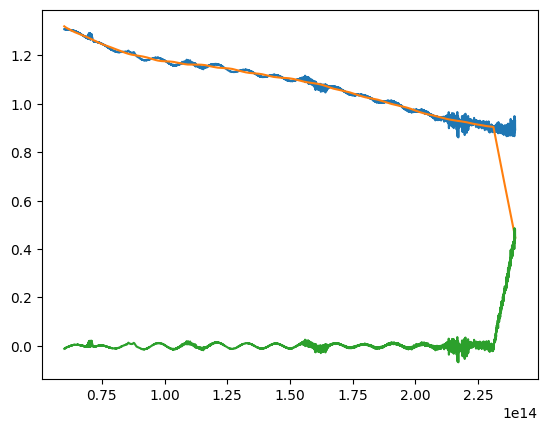

In [287]:
plt.plot(frequenz_s,data[11][:cutoff])
plt.plot(frequenz_s,room_smooth[:cutoff])
plt.plot(frequenz_s,room_smoothed_out)

In [288]:
minima_index_calc_room = scipy.signal.argrelmin(room_smoothed_out, order = 500)
minima_frequenz_room = []
minima_absorption_room = []
for minimum in minima_index_calc_room[0]:
    minima_frequenz_room.append(frequenz[minimum])
    minima_absorption_room.append(room_smoothed_out[minimum])
m_array_room = calculate_m(minima_frequenz_room)
m_array_room = m_array_room[3:]
minima_frequenz_room = minima_frequenz_room[3:]
minima_absorption_room = minima_absorption_room[3:]
m_array_room

[15.434447301614046,
 14.414634155886741,
 12.38379022568226,
 12.337612296752692,
 10.523980839666178,
 10.124207839998222,
 8.475682082499548,
 7.820987671247991,
 7.153153149762617]

In [289]:
m_array_room_clean = np.arange(6,16,1)[::-1] #very weird
m_array_room_clean

array([15, 14, 13, 12, 11, 10,  9,  8,  7,  6])

In [290]:
len(frequenz_s)

12439

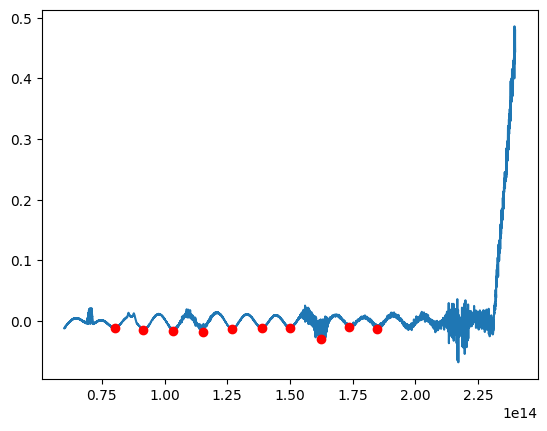

In [291]:
plt.plot(frequenz_s,room_smoothed_out)
plt.plot(minima_frequenz_room,minima_absorption_room,'ro')

### modelling the refractive index

In [292]:
def polynomial(x,a0,a1,a2,a3):
    return a0 + a1*x + a2*x**2 + a3*x**3

def refractive_index(m,L,f):
    wavelength = scipy.constants.c/f
    n = (m * wavelength) / (2 * L)
    return n 

In [293]:
m_array_room_clean

array([15, 14, 13, 12, 11, 10,  9,  8,  7,  6])

In [294]:
minima_frequenz_room

[184826732875360.0,
 173580432377185.78,
 162319676486271.78,
 150191596641236.9,
 138930840720343.62,
 126875037898966.48,
 115469727990716.27,
 103283826544742.78,
 91574953299018.11,
 80343108193583.73]

In [295]:
n_array_minima_room = []
for i in range(len(m_array_room_clean)):
    print(minima_frequenz_room[i])
    print(m_array_room_clean[i])
    n_array_minima_room.append(refractive_index(m_array_room_clean[i],4.6e-6,minima_frequenz_room[i]))
#n_array_minima_room

184826732875360.0
15
173580432377185.78
14
162319676486271.78
13
150191596641236.9
12
138930840720343.62
11
126875037898966.48
10
115469727990716.27
9
103283826544742.78
8
91574953299018.11
7
80343108193583.73
6


In [296]:
n_array_minima_room

[2.644596068343528,
 2.628210496425671,
 2.609786975792324,
 2.603565376587802,
 2.5800427196144318,
 2.56836469007241,
 2.5398451676941094,
 2.5240069295855574,
 2.4908880535171276,
 2.4335232334264703]

In [297]:
minima_frequenz_room

[184826732875360.0,
 173580432377185.78,
 162319676486271.78,
 150191596641236.9,
 138930840720343.62,
 126875037898966.48,
 115469727990716.27,
 103283826544742.78,
 91574953299018.11,
 80343108193583.73]

In [298]:
minima_frequenz_room[:-1]

[184826732875360.0,
 173580432377185.78,
 162319676486271.78,
 150191596641236.9,
 138930840720343.62,
 126875037898966.48,
 115469727990716.27,
 103283826544742.78,
 91574953299018.11]

In [299]:
n_array_minima_room 

[2.644596068343528,
 2.628210496425671,
 2.609786975792324,
 2.603565376587802,
 2.5800427196144318,
 2.56836469007241,
 2.5398451676941094,
 2.5240069295855574,
 2.4908880535171276,
 2.4335232334264703]

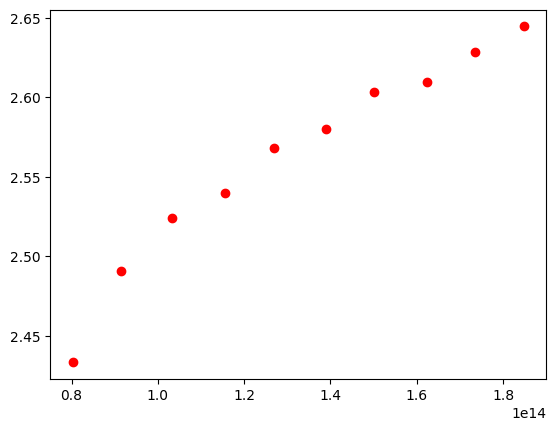

In [300]:
plt.plot(minima_frequenz_room,n_array_minima_room,'ro')

In [301]:
params_J14, cov = scipy.optimize.curve_fit(polynomial, minima_frequenz_room, n_array_minima_room)

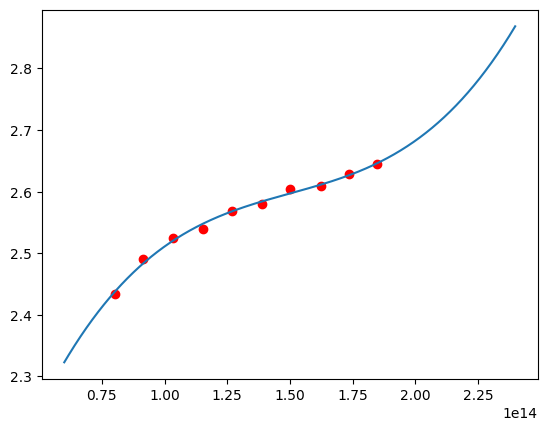

In [302]:
plt.plot(minima_frequenz_room,n_array_minima_room,'ro')
plt.plot(frequenz_s, polynomial(np.array(frequenz_s), *params_J14))

In [303]:
def optdick_total(f):
    return 4.6e-6 * polynomial(np.array(f), *params_J14)

In [304]:
params_STINS = np.array([ 7.62392205e-01,  1.95423832e-14, -9.96420756e-29,  1.83173412e-43])

In [305]:
def optdick_STINS(f): 
    return 3.5e-6 * polynomial(np.array(f), *params_STINS)

In [306]:
def optdick_toppart(f):
    return optdick_total(f) - optdick_STINS(f)

In [307]:
def dispersion_toppart(f):
    return optdick_toppart(f) / 1.1e-6

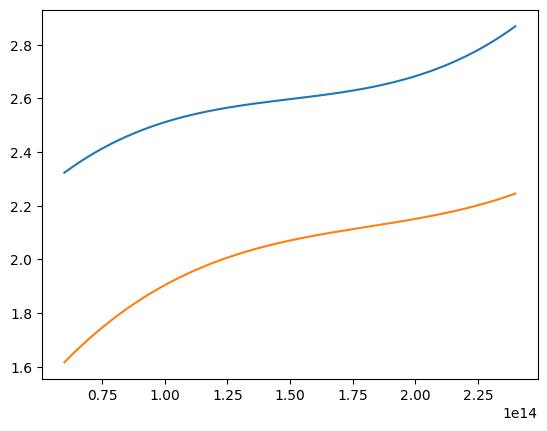

In [308]:
plt.plot(frequenz_s,polynomial(np.array(frequenz_s), *params_J14))
plt.plot(frequenz_s,polynomial(np.array(frequenz_s), *params_STINS))

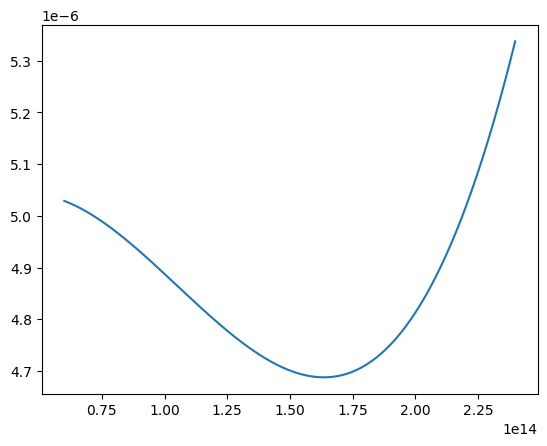

In [309]:
plt.plot(frequenz_s, optdick_toppart(frequenz_s))

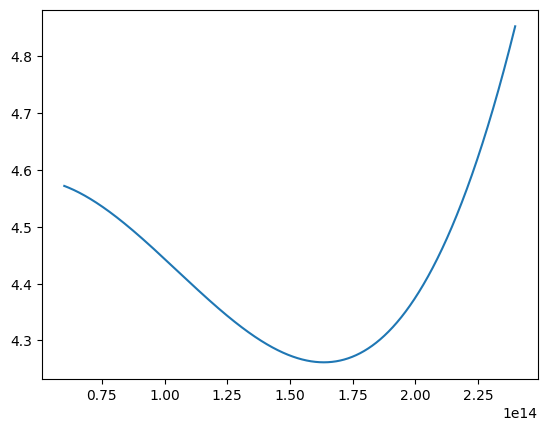

In [310]:
plt.plot(frequenz_s, dispersion_toppart(frequenz_s))

In [311]:
L_array = []
for i in range(len(n_array_minima_room)):
    L_array.append(länge(m_array_room_clean[i],polynomial(minima_frequenz_room[i],*params_J14),minima_frequenz_room[i]))

In [312]:
L_array

[4.597470576523017e-06,
 4.602891765843805e-06,
 4.597431615020677e-06,
 4.611385272290143e-06,
 4.592774302617778e-06,
 4.600897521671057e-06,
 4.585029814256181e-06,
 4.6073936954907106e-06,
 4.613435221814876e-06,
 4.591283740567302e-06]

### Berechnen der Länge bei 90C

In [313]:
for i in range(len(n_array_minima_room)):
    print(n_array_minima_room[i]-polynomial(minima_frequenz_room[i], *params_J14))

-0.0014549964531722637
0.0016511727258698983
-0.0014579744146616669
0.006428068571012968
-0.004059116929502338
0.0005010246278382979
-0.008292629592658418
0.004050389414749667
0.007253951102810241
-0.0046198886927038


In [314]:
data90 = data[12]

In [315]:
cutoff = find_nearest(frequenz, 0.6e14)
cutup = find_nearest(frequenz, 1.8e14)

In [361]:
smooth90,smoothed_out90 = flatten(cutoff,data90,cutup = cutup, N = 1000)

In [362]:
frequenz_s_cut = frequenz[cutup:cutoff]

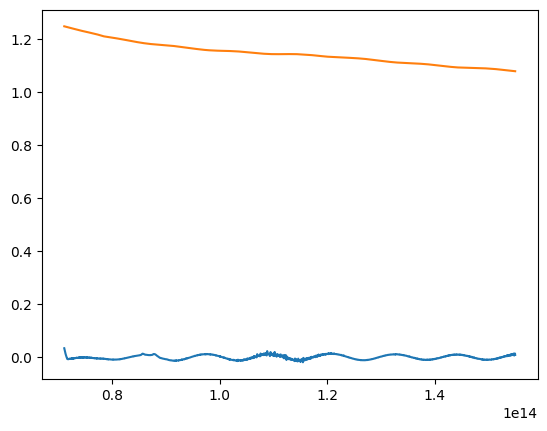

In [363]:
plt.plot(frequenz_s_cut,smoothed_out90)
plt.plot(frequenz_s_cut,smooth90)

In [364]:
minimum_index_90 = scipy.signal.argrelmin(smoothed_out90, order = 500)
minima_frequenz_90 = []
minma_absorption_90 = []
m_array_90 = []
for minimum in minimum_index_90[0]:
    minima_frequenz_90.append(frequenz_s_cut[minimum])
    minma_absorption_90.append(smoothed_out90[minimum])
m_array_90 = calculate_m(minima_frequenz_90)
m_array_90

[12.518954222368773,
 10.911691557797592,
 10.175796164188625,
 8.475682082499548,
 8.010088275796717,
 6.959899753991512]

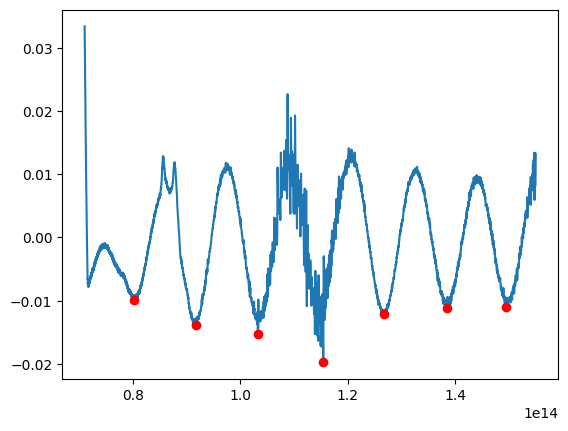

In [365]:
plt.plot(frequenz_s_cut,smoothed_out90)
plt.plot(minima_frequenz_90,minma_absorption_90,'ro')

In [366]:
m_array_90_clean = np.arange(6,15,1)[::-1]

In [367]:
len(m_array_90_clean)

9

In [368]:
n_array_minima_90 = []
for i in range(len(m_array_90_clean)):
    n_array_minima_90.append(polynomial(minima_frequenz_90[i], *params_J14))
n_array_minima_90

IndexError: list index out of range

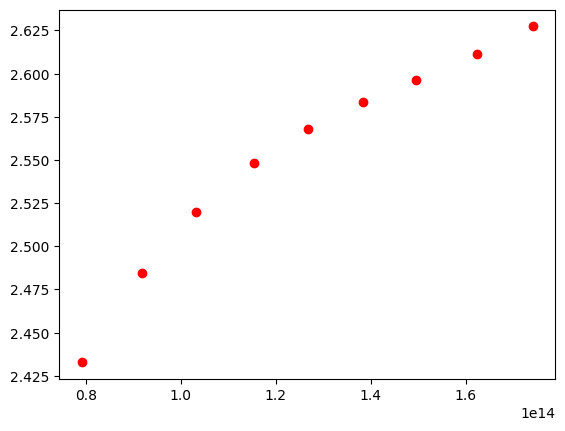

In [345]:
plt.plot(minima_frequenz_90,n_array_minima_90,'ro')

In [346]:
L_array_90 = []
for i in range(len(n_array_minima_90)):
    L_array_90.append(länge(m_array_90_clean[i],n_array_minima_90[i],minima_frequenz_90[i]))

In [347]:
L_array_90

[4.586488234581655e-06,
 4.597431615020677e-06,
 4.634184737458957e-06,
 4.610150022220908e-06,
 4.603152000979514e-06,
 4.585029814256181e-06,
 4.6073936954907106e-06,
 4.599474959715125e-06,
 4.668592338797122e-06]

### For -160C

In [348]:
data_160 = data[13]

In [349]:
cutoff = find_nearest(frequenz, 0.71e14)
cutup = find_nearest(frequenz, 1.55e14)
frequenz_s_cut = frequenz[cutup:cutoff]

In [350]:
smooth160,smoothed_out160 = flatten(cutoff,data_160,cutup = cutup, N = 1400)

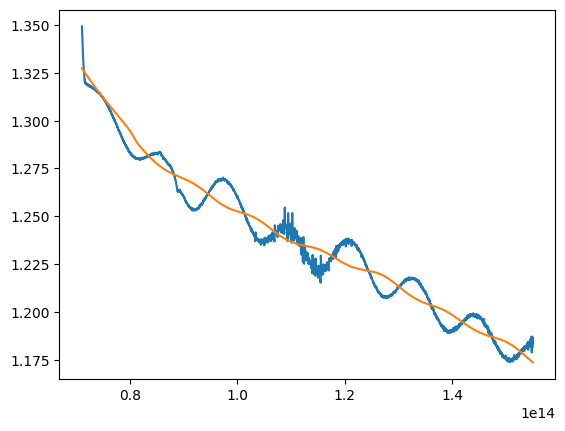

In [330]:
plt.plot(frequenz_s_cut,data_160[cutup:cutoff])
plt.plot(frequenz_s_cut,smooth160)

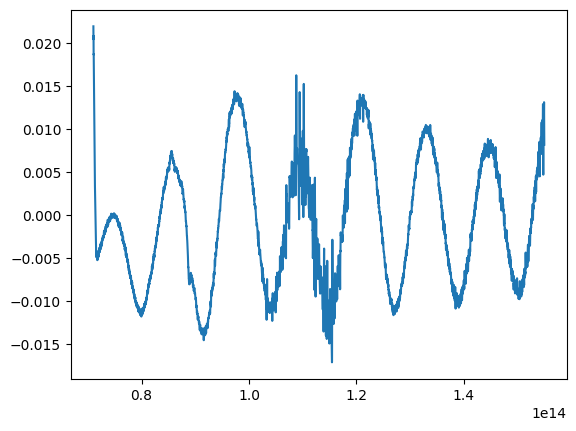

In [331]:
plt.plot(frequenz_s_cut,smoothed_out160)

In [332]:
minimum_index_160 = scipy.signal.argrelmin(smoothed_out160, order = 500)
minima_frequenz_160 = []
minma_absorption_160 = []
m_array_160 = []
for minimum in minimum_index_160[0]:
    minima_frequenz_160.append(frequenz_s_cut[minimum])
    minma_absorption_160.append(smoothed_out160[minimum])
m_array_160 = calculate_m(minima_frequenz_160)
m_array_160

[11.626213585720892,
 10.974999990278516,
 10.071878945764094,
 9.386215867582571,
 7.174405441618059,
 6.8793532251394796]

In [352]:
m_array_160_clean = np.arange(6,13,1)[::-1]
m_array_160_clean   

array([12, 11, 10,  9,  8,  7,  6])

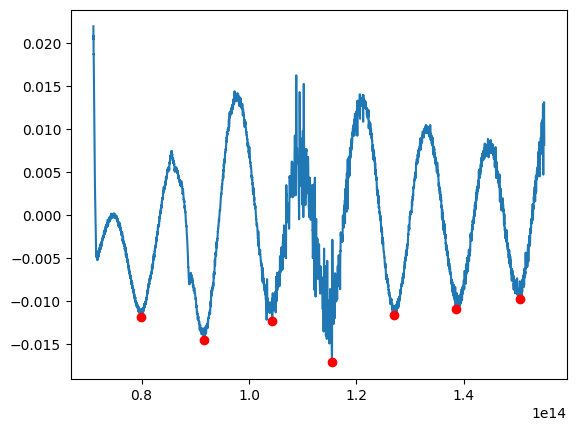

In [353]:
plt.plot(frequenz_s_cut,smoothed_out160)
plt.plot(minima_frequenz_160,minma_absorption_160,'ro')

In [354]:
n_array_minima_160 = []
for i in range(len(m_array_160_clean)):
    n_array_minima_160.append(polynomial(minima_frequenz_160[i], *params_J14))
n_array_minima_160

[2.597365610730244,
 2.583554857644254,
 2.5679291651545486,
 2.548109190044377,
 2.522749641111433,
 2.4836341024143174,
 2.4363499360927783]

In [355]:
L_array_160 = []
for i in range(len(n_array_minima_160)):
    L_array_160.append(länge(m_array_160_clean[i],n_array_minima_160[i],minima_frequenz_160[i]))

In [356]:
L_array_160

[4.604775239699716e-06,
 4.608611606305386e-06,
 4.59920814753385e-06,
 4.5856553574723e-06,
 4.555746779877031e-06,
 4.613435221814876e-06,
 4.6170921862434166e-06]

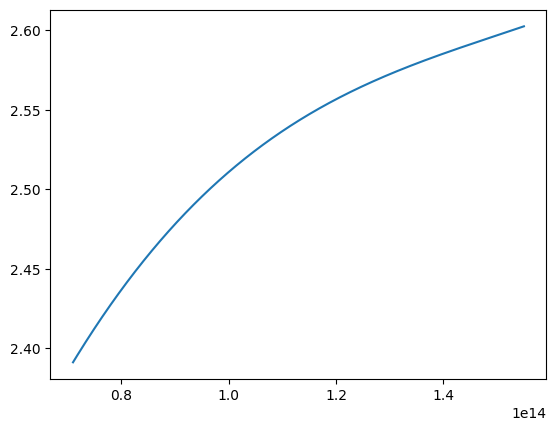

In [357]:
plt.plot(frequenz_s_cut,polynomial(frequenz_s_cut, *params_J14))

In [358]:
print(minima_frequenz_room[3:])
print(m_array_room_clean[3:])

[150191596641236.9, 138930840720343.62, 126875037898966.48, 115469727990716.27, 103283826544742.78, 91574953299018.11, 80343108193583.73]
[12 11 10  9  8  7  6]


In [359]:
print(minima_frequenz_90[2:])
print(m_array_90_clean[2:])

[149497737489931.94, 138439357157334.2, 126817216298027.83, 115469727990716.27, 103283826544742.78, 91820695065533.17, 79186676264749.05]
[12 11 10  9  8  7  6]


In [360]:
print(minima_frequenz_160)
print(m_array_160_clean)

[150393972229532.44, 138482723365532.98, 126918404077185.98, 115455272597976.42, 104339070694419.31, 91574953299018.11, 79952812409732.48]
[12 11 10  9  8  7  6]
